We will be working with a small audio file, a recording of a dolphin.

In [1]:
import librosa

x, sr = librosa.load('data/fragment_6.25_7.75.wav', sr=None, mono=False)

The sample rate of the file is 192000. The recording is 1.5 seconds long.

In [2]:
x.shape[1] / sr

1.5000052083333333

Let's listen to the audio file in our browser!

In [3]:
import IPython.display as ipd

ipd.Audio(x, rate=sr)

This what the amplitude envelope of our recording looks like.

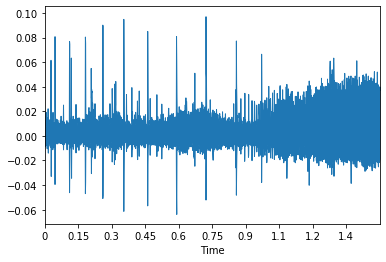

In [4]:
%matplotlib inline
import librosa.display
librosa.display.waveplot(x, sr)

Spectograms are often used to visualize sound. They offer insights into what frequencies make up the sound at any given point in time.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

CPU times: user 693 ms, sys: 19.4 ms, total: 712 ms
Wall time: 119 ms


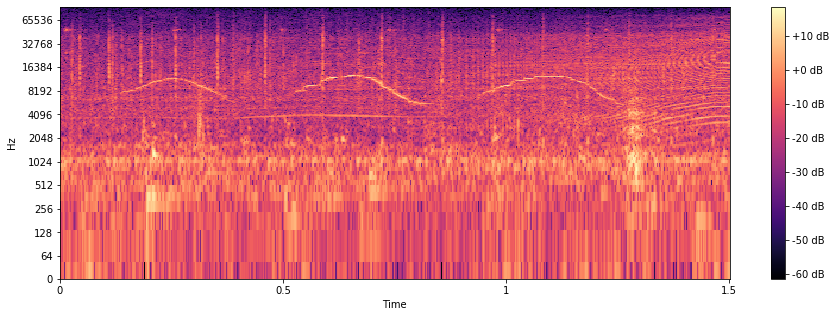

In [6]:
%%time
hop_length = 512
n_fft = 2048
S = librosa.stft(np.asfortranarray(x[0]), n_fft=n_fft, hop_length=hop_length)


S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(15, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB');

Here we are looking at the entire range of recorded frequencies (from 0 to Nyquist frequency which is 1/2 of the sr).

The spectogram above does offer us some good insights. Moving to high resolution spectograms will allow us to visualize finer details. It will also give us better control over the types of sounds we are visualizing.

This function that we will use is `high_resolution_spectogram_float32` (it is defined in `linear_reassignment_pytorch.py`). It takes in a signal, performs reassignment as outlined in the [Sparse Time-Frequency Representations paper](https://doi.org/10.1073/pnas.0601707103) and returns a spectogram.

The function uses a natural coordinate system. Time in samples is 1 to N where N is the count of samples in our signal. Frequency is 0 to 1. In order to reconstruct the real units, time has to be divided by the sampling rate, and frequency gets multiplied by the sampling rate.

The trickiest parameter to understand is `q`, the Q of the wavelet. In the words of the discoverer of the method, Marcelo O. Magnasco:

>The Q of a wavelet is the quotient between its temporal and frequency extent. Our wavelets are ellipses in time-frequency space, their aspect ratio is Q. If Q is >> 1 then the wavelet is frequencylike — it looks like a long oscillation. If Q<<1 then it is timelike, it looks like an impulse in TF space. At 1 it’s a circle in natural units. This code is keeping the Q of the wavelet constant as opposed to keeping the temporal width of the wavelet constant, so the width is reduced at higher frequencies in direct proportion — the wavelets all look identical, just rescaled. 

## Paremeters overview

|parameter|description|
|:------:|:-----------|
|x       |signal, an array of sampled amplitudes with values on the interval from -1 to 1| 
|q       |wavelet's Q, defines the wavelet that will be used to analyze the data<br><br>Altering this parameter, utilizing wavelets of different temporal to frequency extent ratios (different shapes in the time-frequency space), will allow us to zoom in on different aspects of the data. On one extreme, we can follow tone like sounds, on the other click-like sounds. Good values to try when working with tonal sounds are 2, 4, 8 and 1 and 0.5 for impulsive sounds.|
|tdeci   |decimation parameter, how many samples are skipped horizontally<br><br>A signal with 1000 samples and a tdeci of 10 will produce a picture that is 100 pixels wide. The higher the value, tha narrower the picture.|
|over    |oversampling (number of frequencies tried per vertical pixel)<br><br>We oversample frequencies when we make more scan lines than pixels. So if over=5, and our picture is 500 pixels tall, then we will generate 2500 reassignment transforms.|
|noct    |number of divisions per octave (frequency stride in log freq)<br><br>We are scanning frequency in log scale like a piano keyboard, noct is the number of divisions per octave. A piano keyboard has noct=12, or 12 keys per octave.|
|minf    |the smallest frequency to visualize|
|maxf    |the largest frequency to visualize<br><br>The spectogram is symmetric with respect to 0.5 (the nyquist frequency) so maxf should usually be <= 0.5|

## Return value
The returned spectogram has the frequency in log units. It will be of shape:
```
twidth= total samples/tdeci (rounded+1)
fwidth= log2(maxf/minf)*noct (rounded+1)
```

**Note:** Most of the parameter descriptions above come from the function body or personal communication with the discoverer of the method, Marcelo O. Magnasco. I am extremely grateful for the help that he has showed me in understanding the behavior of linear reassignment.

Let's experiment with various parameter values and take a look at the results.

In [7]:
from spectral_hyperresolution.linear_reassignment_pytorch import high_resolution_spectogram

In [8]:
%%time
q = 2
tdeci = 450
over = 20
noct = 12
minf = 4e-3 # 4e-3 corresponds to frequency 4e-3 * sr which is 768 hz
maxf = 0.45
spectogram = high_resolution_spectogram(x.transpose(1, 0), q, tdeci, over, noct, minf, maxf, 'cuda')

CPU times: user 7.76 s, sys: 1.56 s, total: 9.32 s
Wall time: 9.34 s


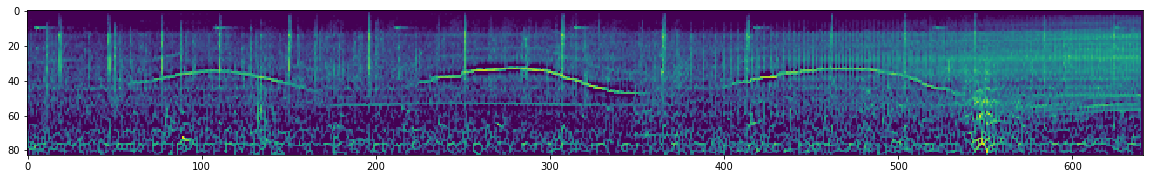

In [9]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(spectogram.cpu().numpy().T));

Linear reassignment delivers a much more detailed view into the structure of the sound.

The first parameter we can look at is `tdeci`. This controls the horizontal stride - how many samples are skipped between performing calculations.

By lowering the `tdeci` parameter we will get a wider image.

In [10]:
tdeci = 300
spectogram = high_resolution_spectogram(x.transpose(1, 0), q, tdeci, over, noct, minf, maxf, 'cuda');

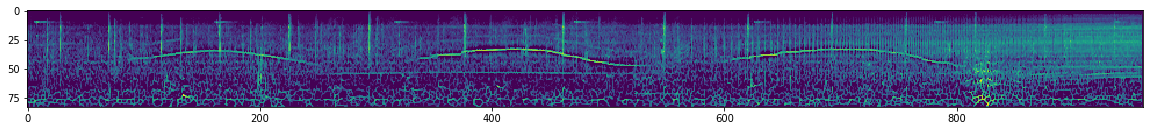

In [11]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(spectogram.cpu().numpy().T));

`over` controls how many frequency scans are performed per each pixel. Let's see if bumping this up from 20 to 40 will give better looking results.

In [12]:
over = 40
spectogram = high_resolution_spectogram(x.transpose(1, 0), q, tdeci, over, noct, minf, maxf, 'cuda');

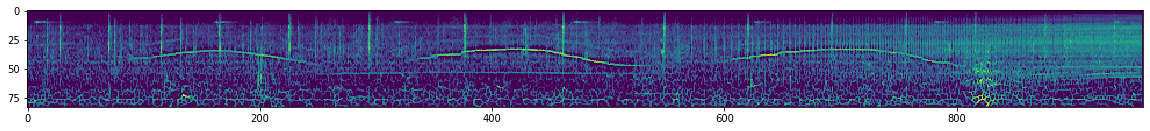

In [13]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(spectogram.cpu().numpy().T));

`over` of 20 was already high enough for our purposes hence we are unable to see much of a difference. It is a useful parameter to be aware of. It trades the execution time for quality of representation.

The `noct` parameter controls how many divisions are performed per octave. The higher the value, the longer the frequency axis.

Thus far we were running with `noct == 12`. If we increase the value to 18, our spectogram should be 1.5x tall.

In [14]:
noct = 18
spectogram = high_resolution_spectogram(x.transpose(1, 0), q, tdeci, over, noct, minf, maxf, 'cuda');

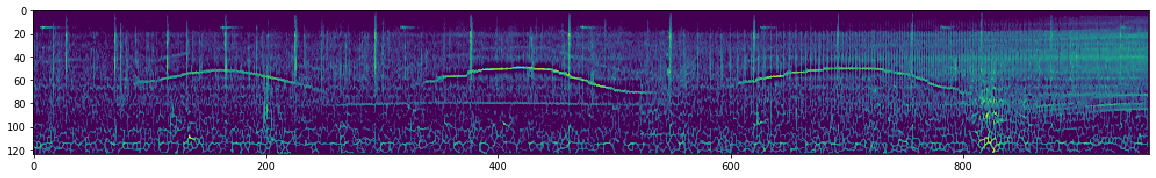

In [15]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(spectogram.cpu().numpy().T));

Thus far we have been using 2 as the value for `q`. A `q` of 2 offers a balance of looking both at click like and tone like sounds (though is probably closer to looking at click like sounds). Let's change `q` to 8 - this should give us a much better representation of tone like sounds.

In [16]:
q = 8
spectogram = high_resolution_spectogram(x.transpose(1, 0), q, tdeci, over, noct, minf, maxf, 'cuda');

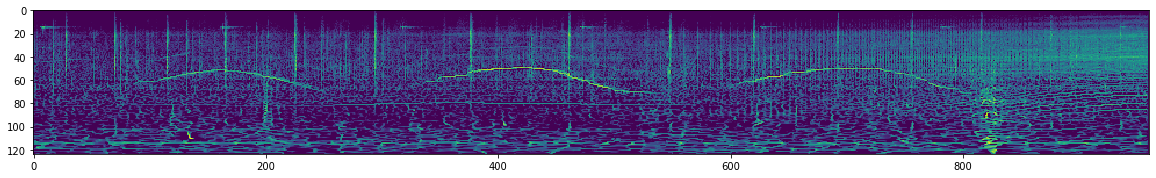

In [17]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(spectogram.cpu().numpy().T));